In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# Machine Learning & Preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score, 
                             mean_squared_error, r2_score, roc_curve, precision_recall_curve)

# Advanced Algorithms
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, IsolationForest
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from xgboost import XGBClassifier

# Handling Imbalance (Critical for Loan Data)
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# Explainability
import shap

# Configuration
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)


In [35]:
# Load the dataset
df = pd.read_excel('loan_dataset.xlsx')

# --- CRITICAL DATA VALIDATION MODULE ---
def check_data_quality(df):
    print("--- 🔍 DATA QUALITY AUDIT ---")
    
    # 1. Check for Nulls
    missing = df.isnull().sum().sum()
    print(f"1. Total Missing Values: {missing} {'⚠️' if missing > 0 else '✅'}")
    
    # 2. Check for Duplicates
    dupes = df.duplicated().sum()
    print(f"2. Duplicate Rows: {dupes} {'⚠️' if dupes > 0 else '✅'}")
    
    # 3. Logic Check: Debt > Income?
    monthly_inc = df['AnnualIncome'] / 12
    impossible_debt = df[df['MonthlyDebtPayments'] > monthly_inc].shape[0]
    print(f"3. High Risk Flags (Debt > Income): {impossible_debt} records")
    
    # 4. Negative Values in Positive Columns
    neg_income = df[df['AnnualIncome'] < 0].shape[0]
    print(f"4. Negative Income Errors: {neg_income} {'❌' if neg_income > 0 else '✅'}")
    
    print("-------------------------------")

check_data_quality(df)

--- 🔍 DATA QUALITY AUDIT ---
1. Total Missing Values: 0 ✅
2. Duplicate Rows: 0 ✅
3. High Risk Flags (Debt > Income): 18 records
4. Negative Income Errors: 0 ✅
-------------------------------


In [36]:
# Convert to datetime
df['ApplicationDate'] = pd.to_datetime(df['ApplicationDate'])

# Extract Features
df['App_Year'] = df['ApplicationDate'].dt.year
df['App_Month'] = df['ApplicationDate'].dt.month
df['App_DayOfWeek'] = df['ApplicationDate'].dt.dayofweek  # 0=Monday, 6=Sunday
df['App_Is_Weekend'] = df['App_DayOfWeek'].apply(lambda x: 1 if x >= 5 else 0)

# Calculate "Days Since" (Simulating vintage analysis)
reference_date = pd.to_datetime('2024-01-01') # Assume current analysis date
df['Days_Since_App'] = (reference_date - df['ApplicationDate']).dt.days

print("✅ Date Features Created: Year, Month, DayOfWeek, Is_Weekend")

✅ Date Features Created: Year, Month, DayOfWeek, Is_Weekend


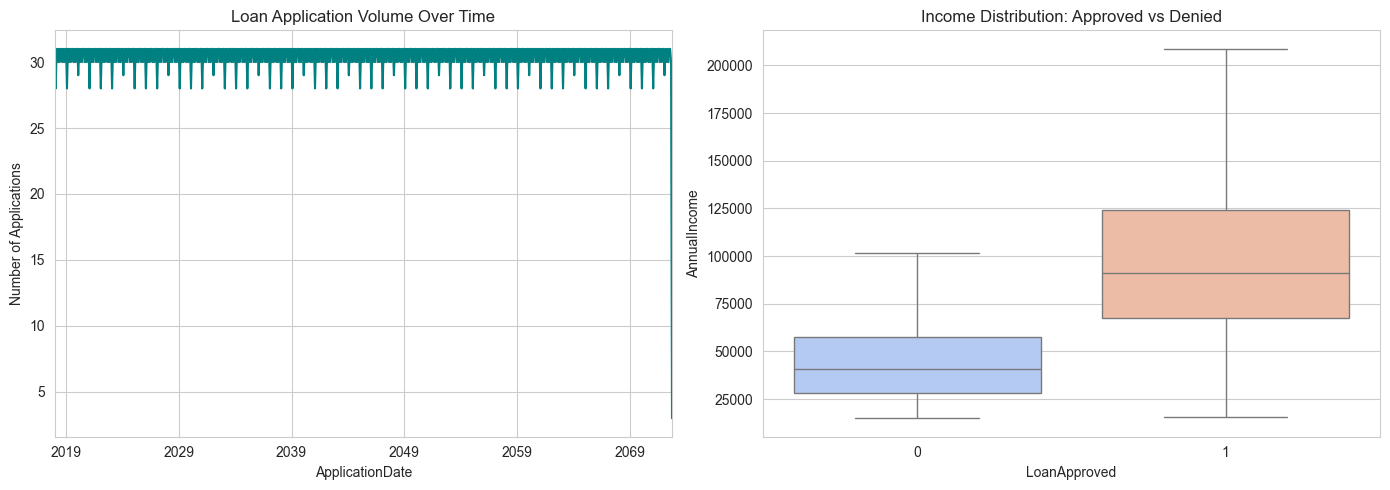

In [38]:
plt.figure(figsize=(14, 5))

# Plot 1: Loan Applications over Time (Monthly)
plt.subplot(1, 2, 1)
df.set_index('ApplicationDate').resample('M').size().plot(color='teal')
plt.title("Loan Application Volume Over Time")
plt.ylabel("Number of Applications")

# Plot 2: Income Distribution by Approval Status
plt.subplot(1, 2, 2)
sns.boxplot(x='LoanApproved', y='AnnualIncome', data=df, showfliers=False, palette='coolwarm')
plt.title("Income Distribution: Approved vs Denied")

plt.tight_layout()
plt.show()

In [39]:
# 1. Monthly Income
df['MonthlyIncome'] = df['AnnualIncome'] / 12

# 2. Debt-to-Income Ratio (DTI)
df['Calculated_DTI'] = (df['MonthlyDebtPayments'] + df['MonthlyLoanPayment']) / (df['MonthlyIncome'] + 1)

# 3. Loan-to-Value Ratio (LTV)
df['LTV'] = df['LoanAmount'] / (df['TotalAssets'] + 1)

# 4. Liquidity Ratio (Runway)
df['Liquidity_Ratio'] = (df['SavingsAccountBalance'] + df['CheckingAccountBalance']) / (df['MonthlyLoanPayment'] + 1)

# 5. Disposable Income
df['Disposable_Income'] = df['MonthlyIncome'] - (df['MonthlyDebtPayments'] + df['MonthlyLoanPayment'])

print("✅ Financial Ratios Calculated")

✅ Financial Ratios Calculated


In [40]:
print("--- 🕵️ ANOMALY DETECTION (ISOLATION FOREST) ---")

# Select features for anomaly detection (Financials only)
anomaly_features = ['AnnualIncome', 'TotalAssets', 'TotalLiabilities', 'LoanAmount']

# Train Isolation Forest
iso_forest = IsolationForest(contamination=0.05, random_state=42) # Assume 5% outliers
df['Is_Anomaly'] = iso_forest.fit_predict(df[anomaly_features])

# Convert -1 (Anomaly) to 1, and 1 (Normal) to 0 for easier understanding
df['Is_Anomaly'] = df['Is_Anomaly'].map({1: 0, -1: 1})

print(f"Anomalies Detected: {df['Is_Anomaly'].sum()} records")
print("Anomaly Flag added as feature 'Is_Anomaly'")

--- 🕵️ ANOMALY DETECTION (ISOLATION FOREST) ---
Anomalies Detected: 1000 records
Anomaly Flag added as feature 'Is_Anomaly'


--- 👥 CUSTOMER SEGMENTATION (K-MEANS) ---


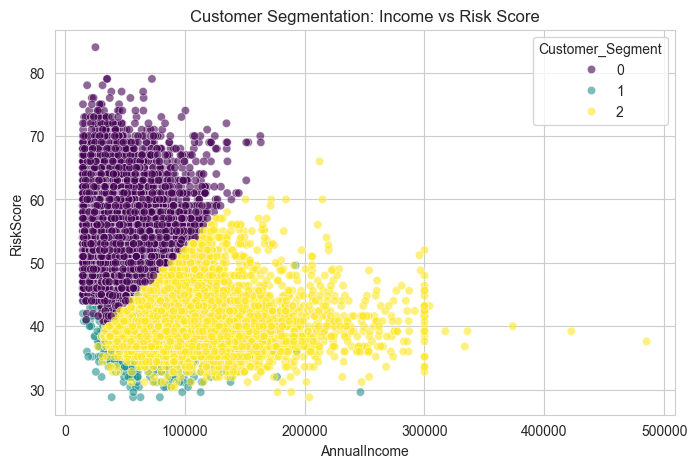

Segmentation Feature 'Customer_Segment' added.


In [41]:
print("--- 👥 CUSTOMER SEGMENTATION (K-MEANS) ---")

# Select features for clustering
cluster_cols = ['AnnualIncome', 'RiskScore', 'TotalAssets']
scaler = StandardScaler()
X_cluster = scaler.fit_transform(df[cluster_cols])

# Train KMeans (Assuming 3 segments: e.g., Low, Mid, High Profile)
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df['Customer_Segment'] = kmeans.fit_predict(X_cluster)

# Visualize Segments
plt.figure(figsize=(8, 5))
sns.scatterplot(x='AnnualIncome', y='RiskScore', hue='Customer_Segment', data=df, palette='viridis', alpha=0.6)
plt.title("Customer Segmentation: Income vs Risk Score")
plt.show()

print("Segmentation Feature 'Customer_Segment' added.")

In [42]:
# Drop non-predictive columns
X = df.drop(columns=['LoanApproved', 'RiskScore', 'ApplicationDate'])
y_class = df['LoanApproved']
y_reg = df['RiskScore']

# Split Data (Stratified for Classification)
X_train, X_test, y_train, y_test = train_test_split(X, y_class, test_size=0.2, random_state=42, stratify=y_class)

# Identify types
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
# Add the new categorical features we created
categorical_cols.extend(['Customer_Segment', 'Is_Anomaly', 'App_Is_Weekend']) 
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
# Remove the categorical ones from numerical list if they got caught there
numerical_cols = [col for col in numerical_cols if col not in categorical_cols]

# Pipeline
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler()) # RobustScaler is better for outliers
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)

print("✅ Preprocessing Pipeline Configured")

✅ Preprocessing Pipeline Configured


In [43]:
print("--- 🚀 STARTING PRODUCTION TRAINING PIPELINE (OBJECTIVE A) ---")

# 1. Define Cross-Validation Strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 2. Define Pipeline (ImbPipeline handles SMOTE correctly to prevent leakage)
pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', XGBClassifier(eval_metric='logloss', random_state=42))
])

# 3. Define Hyperparameters
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__learning_rate': [0.05, 0.1],
    'classifier__max_depth': [4, 6]
}

# 4. Run GridSearchCV
print("⏳ Running Grid Search... (This ensures the best model is found)")
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=cv,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

# 5. Results
best_model = grid_search.best_estimator_
print(f"\n🏆 Best Parameters: {grid_search.best_params_}")
print(f"📈 Best CV AUC Score: {grid_search.best_score_:.4f}")

--- 🚀 STARTING PRODUCTION TRAINING PIPELINE (OBJECTIVE A) ---
⏳ Running Grid Search... (This ensures the best model is found)
Fitting 5 folds for each of 8 candidates, totalling 40 fits

🏆 Best Parameters: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 4, 'classifier__n_estimators': 200}
📈 Best CV AUC Score: 0.9939


--- CLASSIFICATION REPORT ---
              precision    recall  f1-score   support

           0       0.98      0.97      0.98      3044
           1       0.91      0.94      0.93       956

    accuracy                           0.96      4000
   macro avg       0.95      0.96      0.95      4000
weighted avg       0.96      0.96      0.96      4000



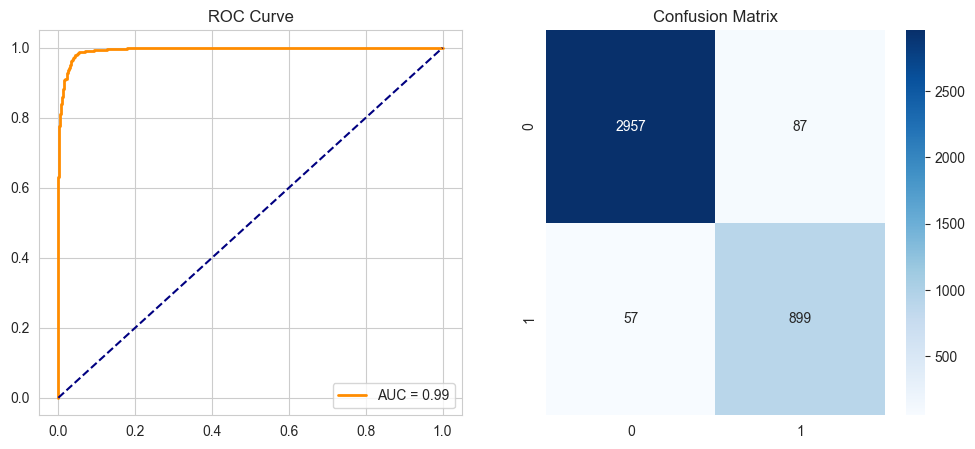

In [44]:
# Predict
y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)[:, 1]

# 1. Classification Report
print("--- CLASSIFICATION REPORT ---")
print(classification_report(y_test, y_pred))

# 2. ROC Curve & Confusion Matrix Plots
plt.figure(figsize=(12, 5))

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc_score(y_test, y_prob):.2f}')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.title('ROC Curve')
plt.legend()

# Confusion Matrix
plt.subplot(1, 2, 2)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

In [33]:
print("--- SAVING MODELS FOR DEPLOYMENT ---")

# Save the Classification Pipeline
joblib.dump(best_clf_model, 'loan_approval_pipeline.pkl')

# Save the Regression Pipeline
joblib.dump(reg_pipeline, 'risk_score_pipeline.pkl')

print("✅ Models saved successfully as .pkl files")
print("   - loan_approval_pipeline.pkl")
print("   - risk_score_pipeline.pkl")

--- SAVING MODELS FOR DEPLOYMENT ---
✅ Models saved successfully as .pkl files
   - loan_approval_pipeline.pkl
   - risk_score_pipeline.pkl


--- OBJECTIVE B: RISK SCORE & RESIDUAL ANALYSIS ---
RMSE: 3.63 points (Lower is better)


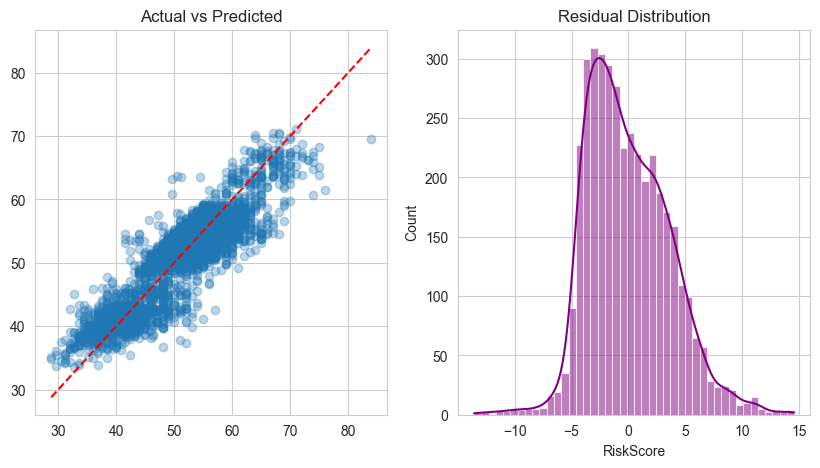

In [45]:
print("--- OBJECTIVE B: RISK SCORE & RESIDUAL ANALYSIS ---")

# Split Data for Regression (using same X features)
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X, y_reg, test_size=0.2, random_state=42)

# Pipeline
reg_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42))
])

reg_pipeline.fit(X_train_reg, y_train_reg)
y_pred_reg = reg_pipeline.predict(X_test_reg)
residuals = y_test_reg - y_pred_reg

# Metrics
rmse = np.sqrt(mean_squared_error(y_test_reg, y_pred_reg))
print(f"RMSE: {rmse:.2f} points (Lower is better)")

# Residual Plot
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(y_test_reg, y_pred_reg, alpha=0.3)
plt.plot([y_test_reg.min(), y_test_reg.max()], [y_test_reg.min(), y_test_reg.max()], 'r--')
plt.title("Actual vs Predicted")

plt.subplot(1, 2, 2)
sns.histplot(residuals, kde=True, color='purple')
plt.title("Residual Distribution")
plt.show()

--- ADVANCED EXPLAINABILITY (SHAP) ---


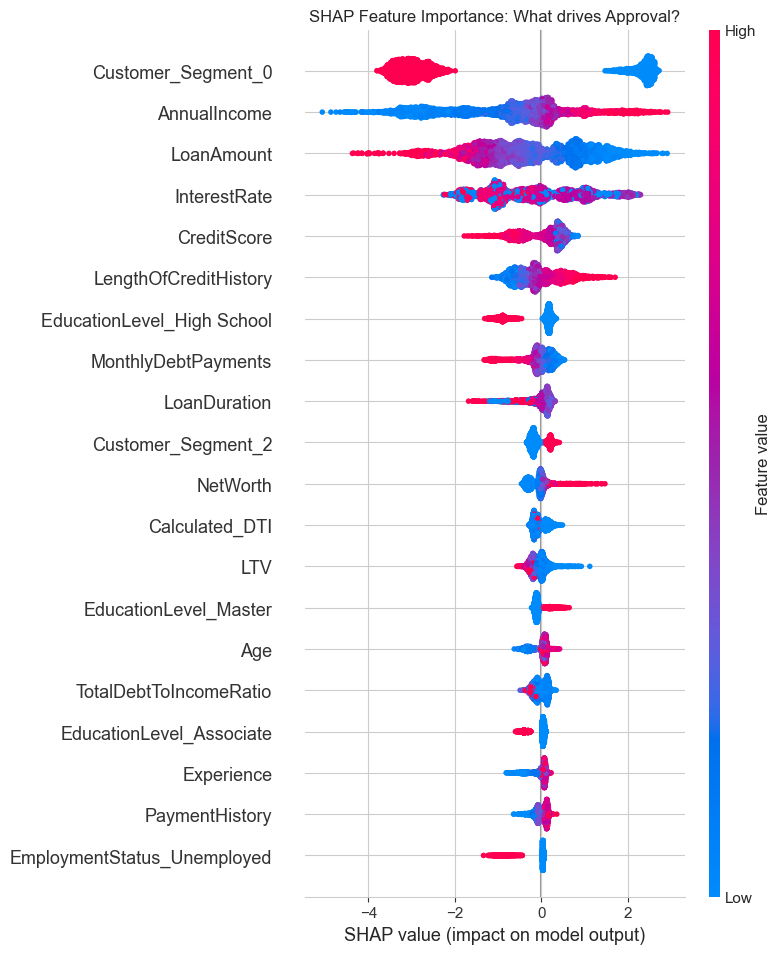

In [46]:
print("--- ADVANCED EXPLAINABILITY (SHAP) ---")

# 1. Prepare Data
# Access the model inside the best pipeline
xgb_model = best_model.named_steps['classifier']
# Transform X_test using the pipeline's preprocessor
X_test_transformed = best_model.named_steps['preprocessor'].transform(X_test)

# 2. Get Feature Names
try:
    ohe = best_model.named_steps['preprocessor'].named_transformers_['cat']['onehot']
    cat_names = ohe.get_feature_names_out(categorical_cols)
    all_feats = numerical_cols + list(cat_names)
except:
    all_feats = [f"Feature {i}" for i in range(X_test_transformed.shape[1])]

# 3. Compute SHAP Values
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test_transformed)

# 4. Summary Plot
plt.figure()
shap.summary_plot(shap_values, X_test_transformed, feature_names=all_feats, show=False)
plt.title("SHAP Feature Importance: What drives Approval?")
plt.show()